In [8]:
import Parity_Data_Generator
import numpy as np
from pyESN import ESN
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
import time

rng = np.random.RandomState(23)

In [9]:
N = 4000   
n = 3       # n-parity
timescale=50
start_time = time.time()
# produce Data
bits, parity, target = Parity_Data_Generator.generateParityData(N, n,timescale=timescale, randomstate=rng)

# Divide in training and test data
traintest_cutoff = int(np.ceil(0.7 * len(bits)))
train_bits, test_bits = bits[:traintest_cutoff], bits[traintest_cutoff:]
train_parity, test_parity = parity[:traintest_cutoff], parity[traintest_cutoff:]
train_targets, test_targets = target[:traintest_cutoff], target[traintest_cutoff:]

print("--- %s seconds ---" % (time.time() - start_time))

--- 0.008502006530761719 seconds ---


In [10]:
nParityESN = ESN(n_inputs=1,
                          n_outputs=1,
                          n_reservoir=300,  
                          spectral_radius=0.6,  
                          leak_rate= 0.3,   # adjust leak_rate
                          delta_t= 0.1,
                          sparsity=0.95,     # 0.95
                          noise=0.01,      # 0.01
                          input_shift=0,    # 0
                          input_scaling=3,  
                          teacher_scaling=1.12,
                          teacher_shift=-0.7,
                          random_state=rng,
                          silent=False)
nParityESN.fit(train_bits, train_parity)#, inspect= True)
predictedParity = nParityESN.predict(test_bits)
    
print("Testing error")
test_error = np.sqrt(np.mean((predictedParity - test_parity) ** 2))
print(test_error)

harvesting states...
fitting...
training error:
0.235668676385
Testing error
0.248154132366


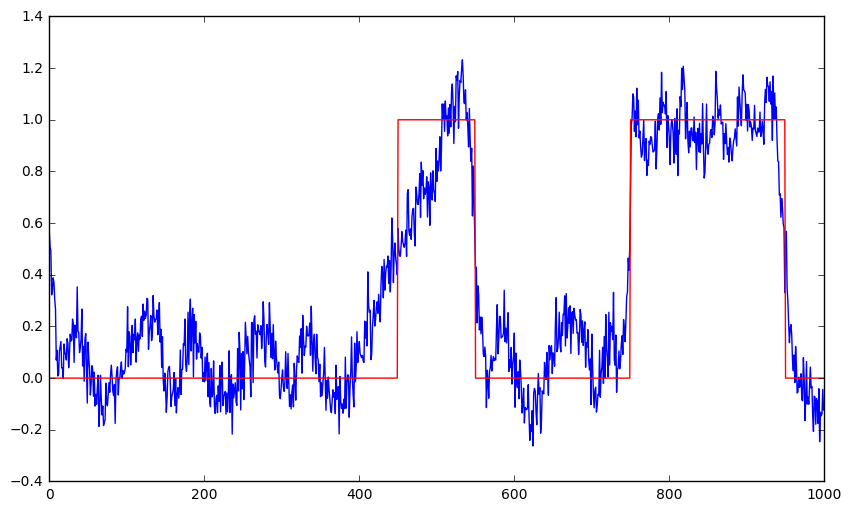

In [11]:
plt.figure(figsize=(10,6))
# plt.subplot(111)
# plt.plot(predictedParity[66600:66800])
plt.plot(predictedParity[6000:7000],"b")
plt.plot(test_parity[6000:7000],"r")
plt.show()

In [12]:
##### Create Training Data for fastESN with output from slowESN
start_time = time.time()

new_rng = np.random.RandomState(1337)
new_N = 3000
new_bits, new_parity, new_target = Parity_Data_Generator.generateParityData(new_N, n, timescale=timescale, randomstate=new_rng)

# Divide in training and test data
traintest_cutoff = int(np.ceil(0.7 * len(new_bits)))
new_train_bits, new_test_bits = new_bits[:traintest_cutoff], new_bits[traintest_cutoff:]
# new_train_parity, new_test_parity = new_parity[:traintest_cutoff], new_parity[traintest_cutoff:]
new_train_targets, new_test_targets = new_target[:traintest_cutoff], new_target[traintest_cutoff:]

train_predicted_parity = nParityESN.predict(new_train_bits)
test_predicted_parity = nParityESN.predict(new_test_bits)

print("--- %s seconds ---" % (time.time() - start_time))

--- 9.051276206970215 seconds ---


In [13]:
outputESN = ESN(n_inputs=1,
                              n_outputs=1,
                              n_reservoir=50,  
                              spectral_radius=0.8,  # 0.95
                              leak_rate= 0.7,   # 0.6
                              delta_t= 0.1,
                              sparsity=0.95,     # 0.95
                              noise=0.01,
                              input_shift=0,  # 0
                              input_scaling=3,  # 
                              teacher_scaling=1.12,
                              teacher_shift=-0.4,
                              random_state=new_rng,
                              silent=False)
outputESN.fit(train_predicted_parity, new_train_targets)
pred_targets = outputESN.predict(test_predicted_parity) # what was predicted from slowESN

print("Testing error")
test_error = np.sqrt(np.mean((pred_targets - new_test_targets) ** 2))
print(test_error)

harvesting states...
fitting...
training error:
0.20660836602
Testing error
0.200079981087


45000


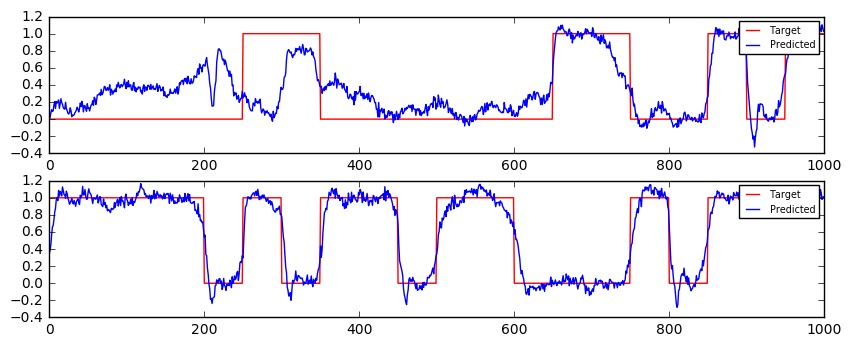

In [19]:
# Show Plots
# print(test_targets)
print(len(new_test_targets))
plt.figure(figsize=(10,6))

# plt.subplot(311)
# plt.plot(new_test_targets[0:1000], "r", label="Target")
# plt.plot(pred_targets[0:1000], "b", label="Predicted")
# plt.legend(fontsize="x-small")

plt.subplot(312)
plt.plot(new_test_targets[1000:2000], "r", label="Target")
plt.plot(pred_targets[1000:2000], "b", label="Predicted")
plt.legend(fontsize="x-small")

plt.subplot(313)
plt.plot(new_test_targets[8000:9000], "r", label="Target")
plt.plot(pred_targets[8000:9000], "b", label="Predicted")
plt.legend(fontsize="x-small")
plt.show()